In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re

In [2]:
df = pd.read_csv('Dados/Noticias_ibov.csv', index_col=0)
variacao = df.Variacao.dropna()

In [3]:
variacao = np.array(variacao.values.tolist())
variacao = variacao.reshape(variacao.shape[0], 1)
variacao.shape

(1556, 1)

In [4]:
variacao_mean = np.mean(variacao)
variacao_std = np.std(variacao)
variacao_mean

0.04365785873971097

In [5]:
n_ruim = variacao_mean - 0.6*variacao_std
n_bom = variacao_mean + 0.6*variacao_std

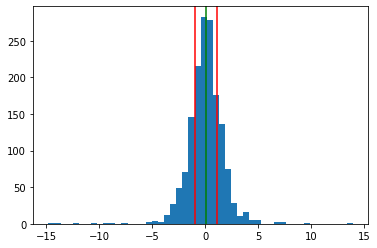

In [6]:
plt.hist(variacao, 50, histtype='bar', align='mid')
plt.axvline(x = n_ruim, color='r')
plt.axvline(x = n_bom, color='r')
plt.axvline(x = variacao_mean, color = 'g')
plt.show()

In [7]:
def classificar(x):
    if n_ruim >= x:
        return 0
    elif n_ruim < x < n_bom:
        return 1
    elif x >= n_bom:
        return 2
    else:
        return np.nan

In [8]:
df['classificacao'] = df.Variacao.apply(classificar)

In [9]:
df.classificacao.value_counts()

1.0    879
2.0    345
0.0    332
Name: classificacao, dtype: int64

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords_port = set(stopwords.words('portuguese'))

def retorna_lista (phrases):
    all_words_phrases = []
    all_words_phrases.append(ast.literal_eval(phrases))
    all_words_phrases = [item.lower() for sublist in all_words_phrases for item in sublist]
    all_words_phrases = [re.sub(r'\d+', '', phrase) for phrase in all_words_phrases]
    all_words_phrases = [re.sub(r'[^\w]', ' ', phrase) for phrase in all_words_phrases]
    all_words_phrases = [' '.join(phrase.split()) for phrase in all_words_phrases]
    # all_phrases_filtered = [word_tokenize(phrase) for phrase in all_words_phrases]
    # all_phrases_filtered = [w for phrase in all_phrases_filtered for w in phrase if not w in stopwords_port]
    return all_words_phrases

In [13]:
dados_modelo_temp = pd.DataFrame()
dados_modelo_temp['frases_globo'] = df.frases_globo.apply(lambda phrases: retorna_lista(phrases) if pd.notnull(phrases) else [])
dados_modelo_temp['frases_folha'] = df.frases_folha.apply(lambda phrases: retorna_lista(phrases) if pd.notnull(phrases) else [])
dados_modelo_temp['classificacao'] = df['classificacao']

In [14]:
dados_modelo = pd.DataFrame()
dados_modelo = dados_modelo_temp.explode('frases_globo')
dados_modelo_temp = dados_modelo_temp.drop(['frases_globo'], axis = 1)
dados_modelo = dados_modelo.drop(['frases_folha'], axis=1)
dados_modelo = dados_modelo.dropna(subset=['frases_globo'])
dados_modelo = dados_modelo.bfill()

In [15]:
dados_modelo_temp = dados_modelo_temp.explode('frases_folha')
dados_modelo_temp = dados_modelo_temp.dropna(subset=['frases_folha'])
dados_modelo_temp = dados_modelo_temp.bfill()

In [16]:
dados_modelo_temp.columns = ['frase', 'classificador']
dados_modelo.columns = ['frase', 'classificador']
dados_modelo = pd.concat([dados_modelo, dados_modelo_temp])
dados_modelo = dados_modelo.dropna()
dados_modelo

,frase,classificador
Data,,
2014-01-01,belfort concorre a prêmio de melhor lutador do...,2.0
2014-01-01,nadal precisa de mais de duas horas para vence...,2.0
2014-01-01,retrospectiva país festeja títulos mundiais no...,2.0
2014-01-02,central do mercado inter contrata dois zagueir...,2.0
2014-01-02,recuperado de lesão messi se reapresenta e tre...,2.0
...,...,...
2017-09-29,não conheci hugh hefner mas o incomodei por um...,1.0
2017-09-29,ter ou não ter,1.0
2017-09-29,tem muita delação mentirosa diz haddad ao ser ...,1.0


In [18]:
from gensim.models import Word2Vec as w2v
model = w2v.load('word2vec_100_no_num.model')

In [19]:
def vec_2_word(word, model=model):
    try:
        return model[word]
    except KeyError:
        print(f'a palavra {word} não está no vocabulário')
        return 0

In [20]:
def retorna_vetor(phrase):
    vector = [vec_2_word(word) for word in phrase.split()]
    return vector

In [21]:
dados_modelo['vetor'] = dados_modelo.frase.apply(lambda phrases: np.array(retorna_vetor(phrases)))
dados_modelo.head()

a palavra gonna não está no vocabulário
a palavra gimme não está no vocabulário
a palavra cannot não está no vocabulário
a palavra wanna não está no vocabulário
a palavra gimme não está no vocabulário


,frase,classificador,vetor
Data,,,
2014-01-01,belfort concorre a prêmio de melhor lutador do...,2.0,"[[-0.4565319, 0.2579745, 0.047380272, -0.07483..."
2014-01-01,nadal precisa de mais de duas horas para vence...,2.0,"[[-0.6065293, 0.3265774, 0.3728341, -0.0034271..."
2014-01-01,retrospectiva país festeja títulos mundiais no...,2.0,"[[-0.22920139, 0.31408638, 0.33220178, -0.1530..."
2014-01-02,central do mercado inter contrata dois zagueir...,2.0,"[[0.098625965, 0.11010713, 0.45690027, -0.5258..."
2014-01-02,recuperado de lesão messi se reapresenta e tre...,2.0,"[[-0.30037597, 0.13249484, 0.029900417, -0.085..."


In [22]:
dados_modelo['media'] = dados_modelo.vetor.apply(np.mean, axis=0)
dados_modelo['media'] = dados_modelo.media.apply(np.atleast_2d)

In [24]:
dados_modelo.to_pickle('Dados/Dados_modelo_3_classes.plk')